In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

from keras_transfer_learning.utils import visualize
visualize.set_default_plotting()

Using TensorFlow backend.


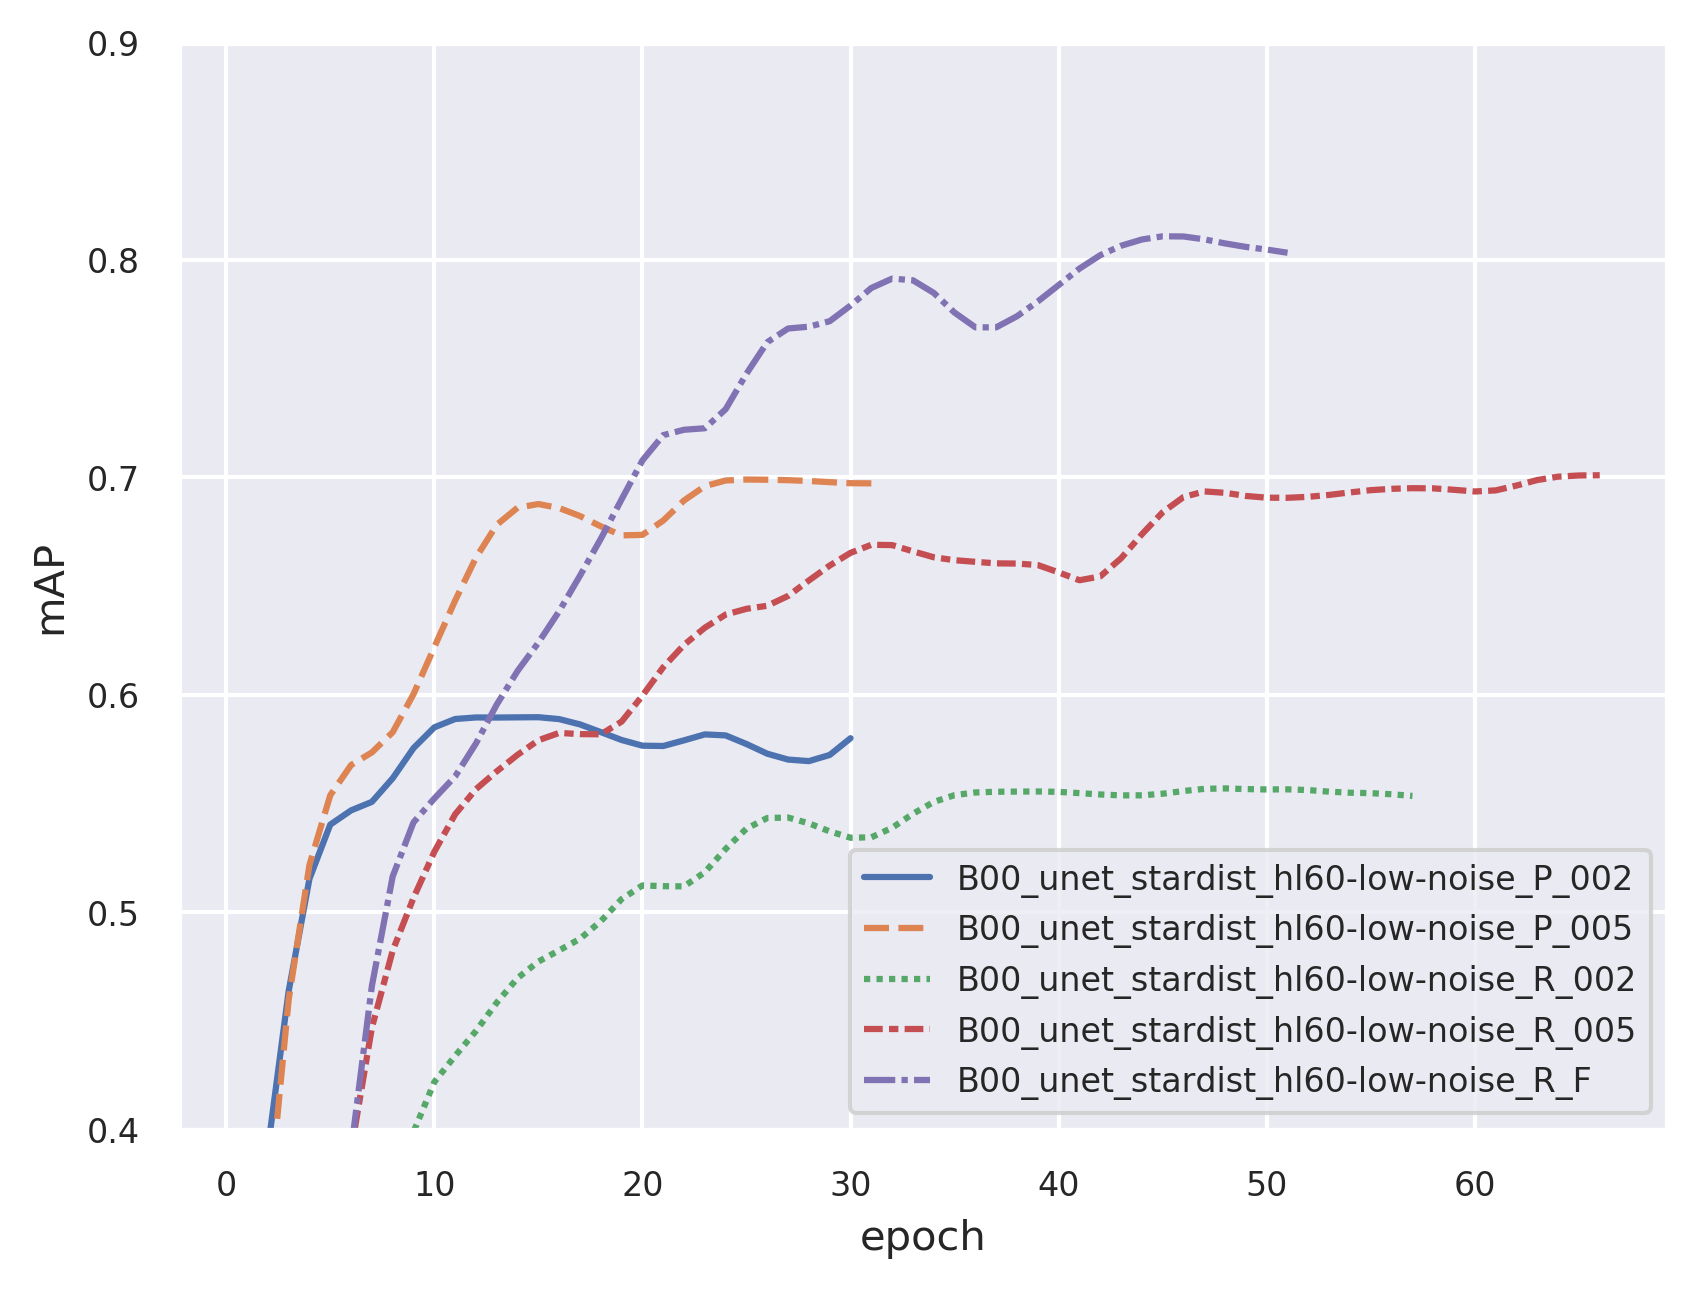

In [2]:
fig = visualize.plot_map_over_epoch('B00_.*_hl60-low-noise.*_(002|005|F)')
# fig.savefig('/tmp/test.pdf')

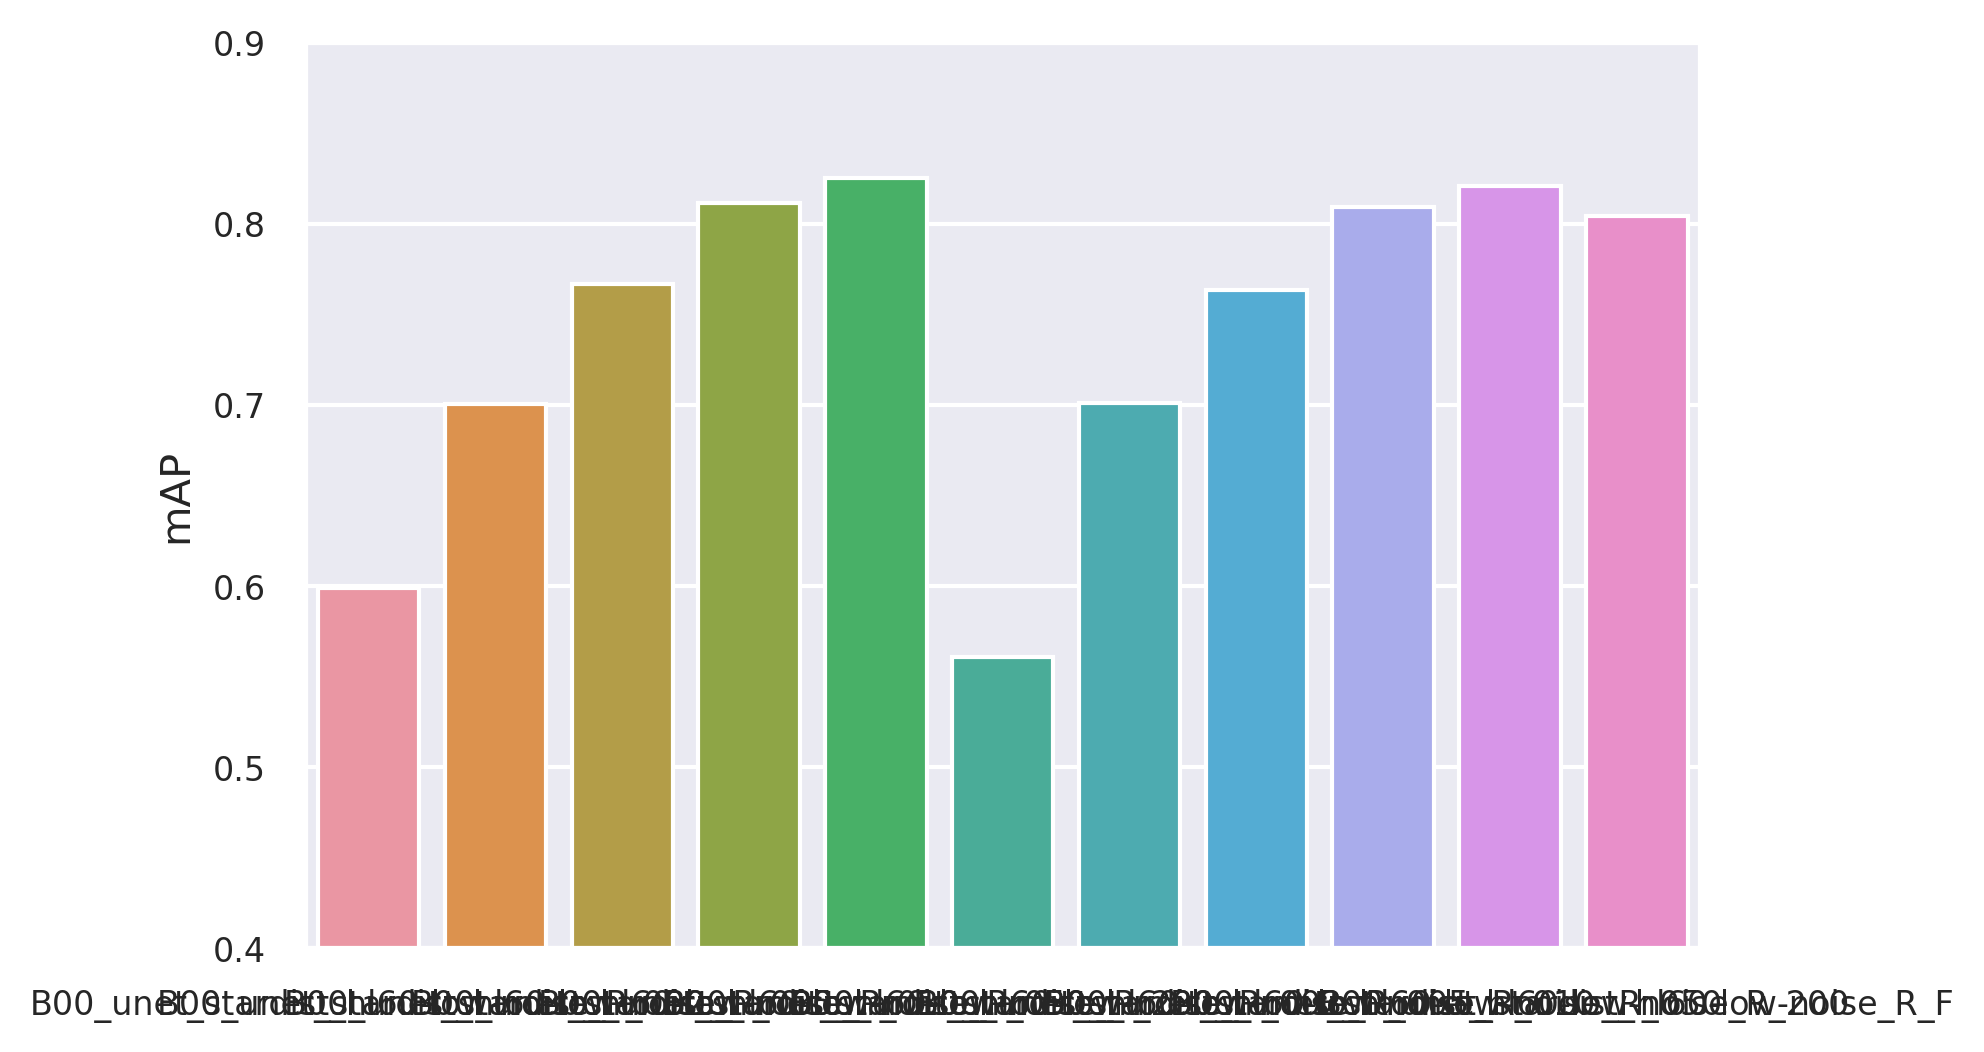

In [3]:
fig = visualize.plot_map_last('B00_.*_hl60', size=(6,4))

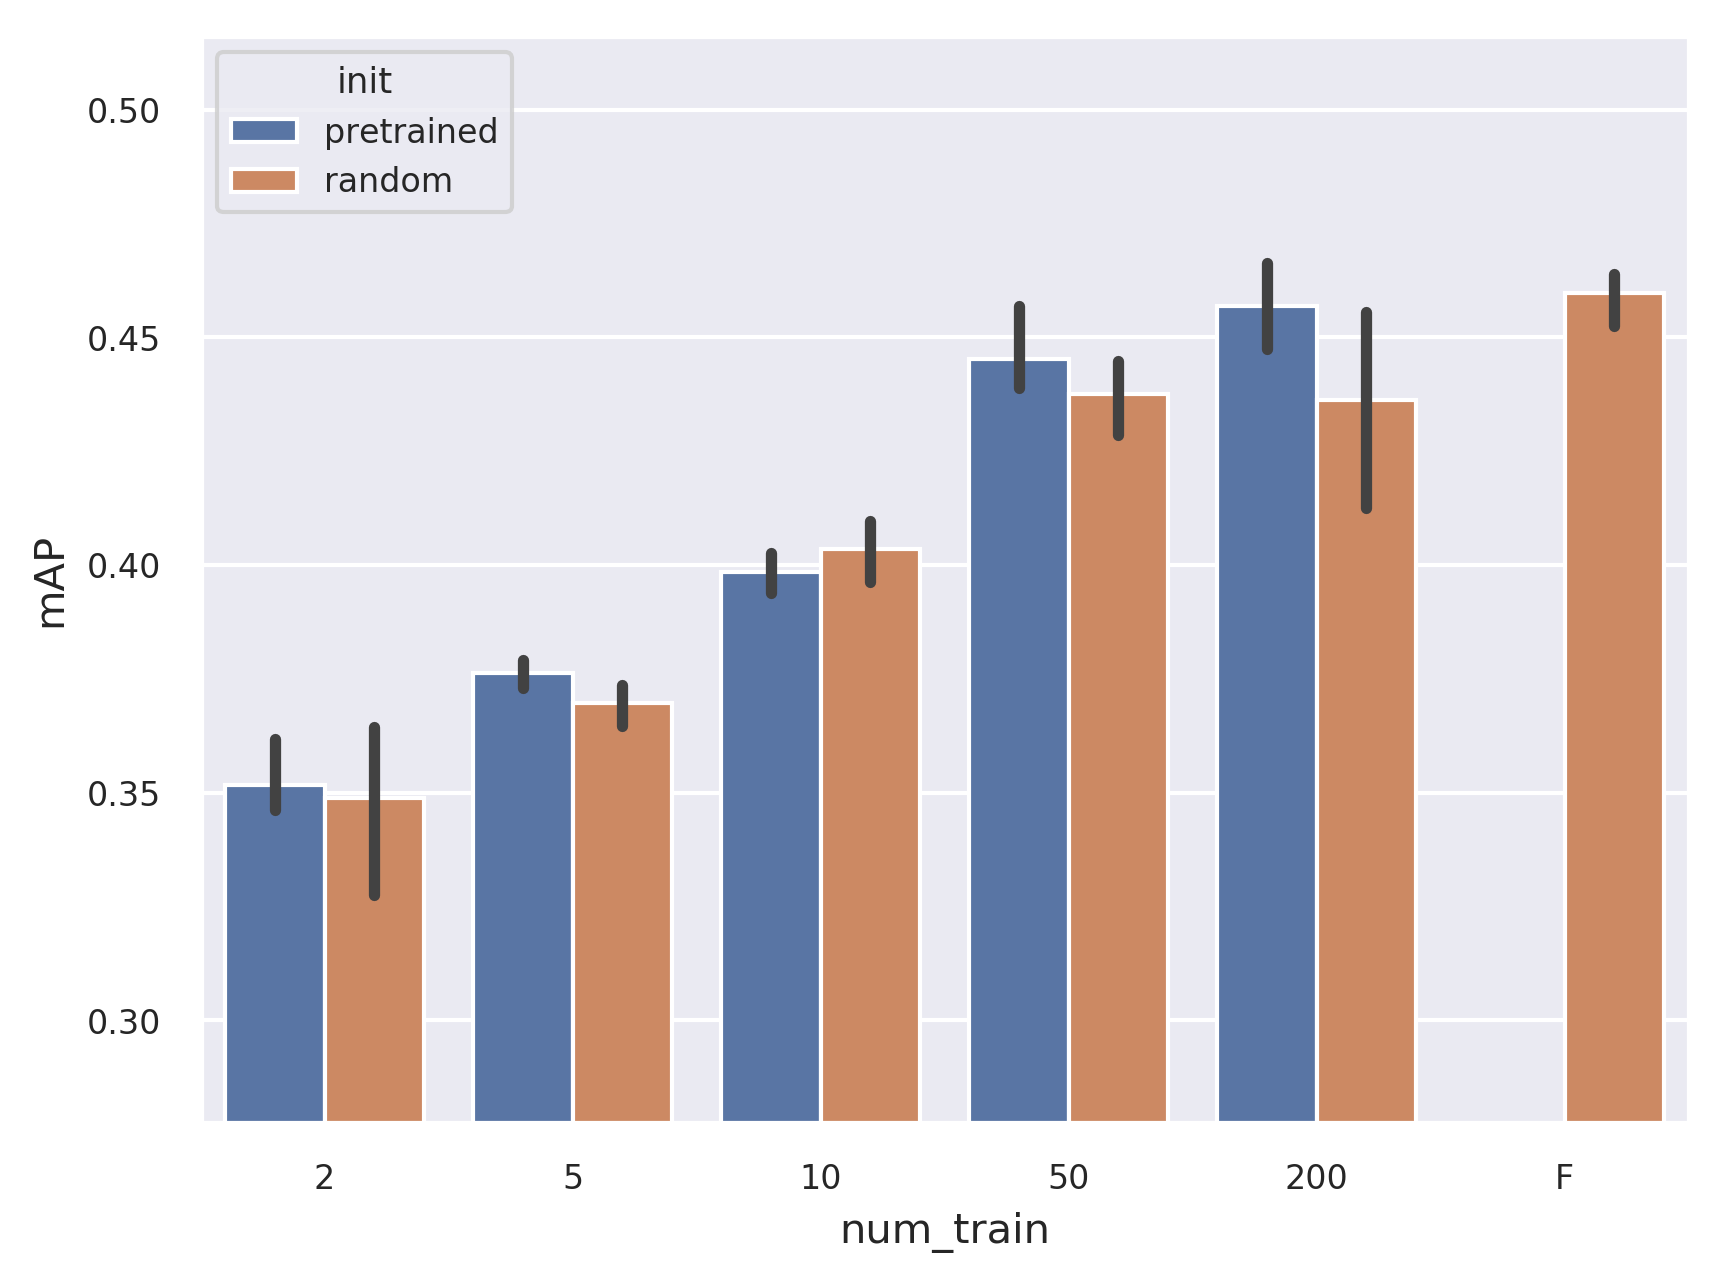

In [7]:
fig = visualize.plot_map_last_compare('B[0-9][0-9]_.*_granulocyte')